##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode="categorical")

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical")

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


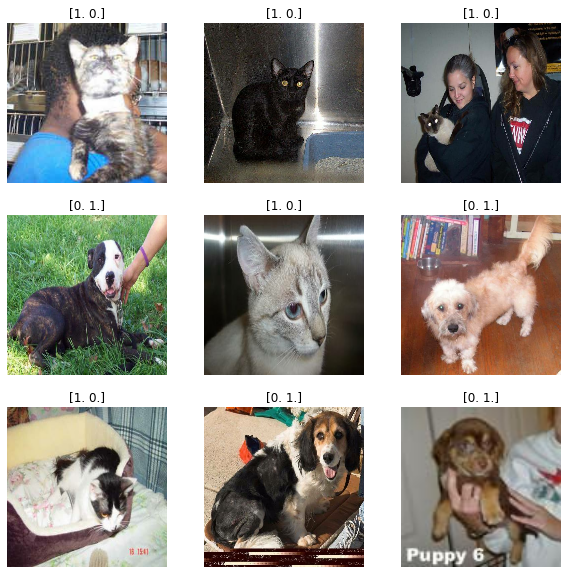

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

Take a moment to look at the APIs and look for other techniques. Which ones do you think there are?

https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation

https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation


In [ ]:
# Here we define the data augmentation
data_augmentation = tf.keras.Sequential([ #Make use of the Sequential approach (not functional)
  tf.keras.layers.RandomFlip('horizontal'), # horizontal flipping
  tf.keras.layers.RandomRotation(0.2), # randomly rotate by 0.2*2pi
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

You can execute this cell a few times to see all the different results!

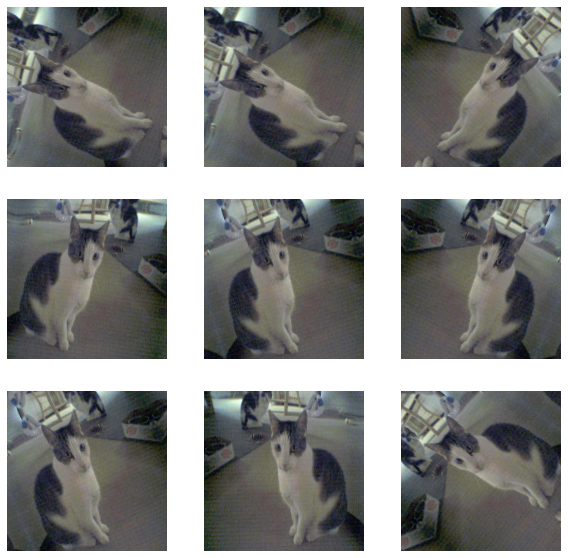

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Note: If using other `tf.keras.applications`,** be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SIZE

(160, 160)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,) # this creates (160,160,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
# Create one batch of data
image_batch, label_batch = next(iter(train_dataset))

# Put the batch into the model
feature_batch = base_model(image_batch)

# View the shape of the tensors which correspond to the 
# last layer from the feature extractor
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
# Freeze the feature extractor (so we will not fine-tune the feature extractor)
# Less parameters this way
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

Apply global average pooling (cheapter than using fully connected layers)

In [ ]:
feature_batch_average = tf.keras.layers.GlobalAveragePooling2D()(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Next, our usual softmax output

In [ ]:
prediction_batch = tf.keras.layers.Dense(2, activation="softmax")(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


The model

In [ ]:
# Define the input
inputs = tf.keras.Input(shape=(160, 160, 3))

# Add augmentation
#x = data_augmentation(inputs)

x = tf.keras.layers.RandomFlip('horizontal')(x) # horizontal flipping
x =  tf.keras.layers.RandomRotation(0.2)(x) # randomly rotate by 0.2*2pi

# Then we preprocess to match the data for which the model was trained on
x = preprocess_input(x)

# The feature extractor
x = base_model(x, training=False)

# Add global average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Some regularisation
x = tf.keras.layers.Dropout(0.2)(x)

# Output
x = tf.keras.layers.Dense(2, activation="softmax")(x)

# The full model
model = tf.keras.Model(inputs, x)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

# For the fun of it, how does the model perform on the pre-trained weights
# with no training
loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 [==============================] - 4s 48ms/step - loss: 0.7568 - accuracy: 0.5890


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.59


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 86ms/step - loss: 0.6273 - accuracy: 0.6845 - val_loss: 0.3927 - val_accuracy: 0.8250
Epoch 2/10
63/63 [==============================] - 5s 81ms/step - loss: 0.4334 - accuracy: 0.8005 - val_loss: 0.2625 - val_accuracy: 0.9010
Epoch 3/10
63/63 [==============================] - 5s 79ms/step - loss: 0.3607 - accuracy: 0.8440 - val_loss: 0.1950 - val_accuracy: 0.9400
Epoch 4/10
63/63 [==============================] - 5s 80ms/step - loss: 0.2962 - accuracy: 0.8720 - val_loss: 0.1589 - val_accuracy: 0.9540
Epoch 5/10
63/63 [==============================] - 5s 80ms/step - loss: 0.2470 - accuracy: 0.9025 - val_loss: 0.1374 - val_accuracy: 0.9590
Epoch 6/10
63/63 [==============================] - 5s 81ms/step - loss: 0.2152 - accuracy: 0.9125 - val_loss: 0.1193 - val_accuracy: 0.9640
Epoch 7/10
63/63 [==============================] - 5s 83ms/step - loss: 0.2159 - accuracy: 0.9080 - val_loss: 0.1050 - val_accuracy: 0.9720
Epoch 8/10
63

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

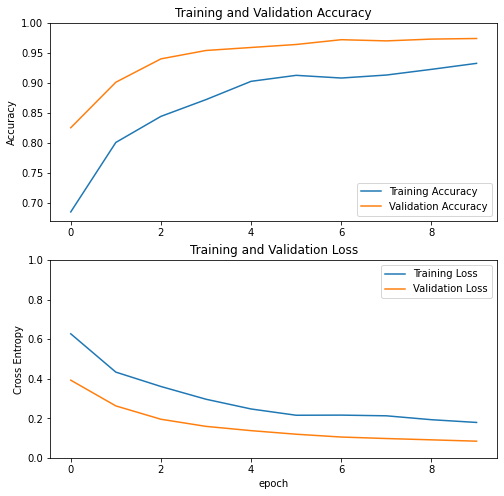

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note that this approach doesn't allow you to decide on how many extra samples you will create. Here, when a batch is fed through the network, it essentially passes through the Sequential layer to augment the data. One advantage of this approach is that you will be able to use GPU acceleration.

# Tasks: 

* explore the different augmentation techniques

* do the epochs take longer to run with more augmentation?

* how does performance change when certain augmentation techniques are used?

* which one(s) performed best?

* which one(s) performed worst?